In [3]:
import os
import pandas as pd
from sklearn.model_selection import train_test_split
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import torch.nn as nn
import torch.optim as optim
import torchvision.models as models
import time
from torch.autograd import Variable
from PIL import Image
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import shutil
import numpy as np
import random
from sklearn.metrics import classification_report, confusion_matrix

In [4]:
seed = 3
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [5]:
data_path='/kaggle/input/genderclassificationdataset'
os.listdir(data_path)

['gender_classification.xlsx',
 'list_attribute.txt',
 'gender_classification.csv',
 'Images',
 'class_identity.txt',
 'list_atrribute_new.txt']

In [6]:
data_files = []
for i in os.listdir(data_path):
  data_files.append(data_path + "/" + i)
data_files

['/kaggle/input/genderclassificationdataset/Dataset/gender_classification.xlsx',
 '/kaggle/input/genderclassificationdataset/Dataset/list_attribute.txt',
 '/kaggle/input/genderclassificationdataset/Dataset/gender_classification.csv',
 '/kaggle/input/genderclassificationdataset/Dataset/Images',
 '/kaggle/input/genderclassificationdataset/Dataset/class_identity.txt',
 '/kaggle/input/genderclassificationdataset/Dataset/list_atrribute_new.txt']

In [7]:
images_list = os.listdir(data_path+'/Images')
len(images_list)

5017

In [8]:
data = pd.read_csv(data_path+"/list_atrribute_new.txt", delim_whitespace=True)
data =  data[data["202599"].isin(images_list)]
data = data[["202599", "Male"]]
data["Male"] = data["Male"].replace(-1, 0)
data.rename(columns={'202599': 'Image'}, inplace=True)
len(data)

/tmp/ipykernel_34/162355186.py:1: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  data = pd.read_csv(data_path+"/list_atrribute_new.txt", delim_whitespace=True)


5000

In [9]:
data.head()

,Image,Male
50,000051.jpg,1
51,000052.jpg,1
64,000065.jpg,1
165,000166.jpg,1
197,000198.jpg,0


In [10]:
train_data, test_data = train_test_split(data, test_size=0.3, random_state=42)
train_data.reset_index(inplace = True, drop = True)

/kaggle/input/genderclassificationdataset/Dataset/Images/073827.jpg
/kaggle/input/genderclassificationdataset/Dataset/Images/084910.jpg
/kaggle/input/genderclassificationdataset/Dataset/Images/179725.jpg
/kaggle/input/genderclassificationdataset/Dataset/Images/046299.jpg
/kaggle/input/genderclassificationdataset/Dataset/Images/099422.jpg
/kaggle/input/genderclassificationdataset/Dataset/Images/001782.jpg


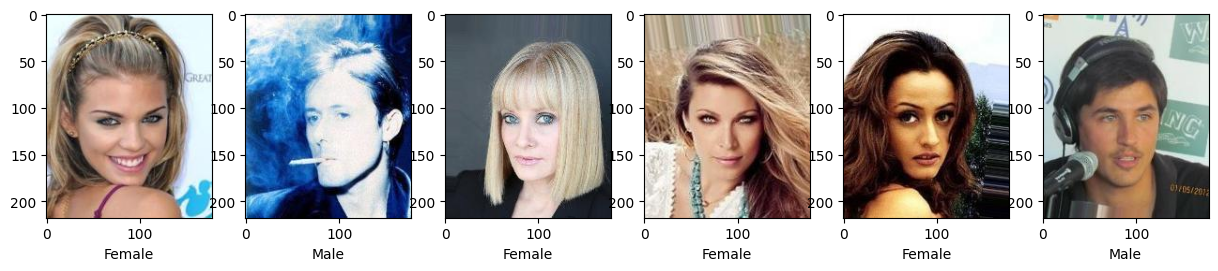

In [11]:
import cv2

def dataset_getitem(image_folder_path, data, idx):
    fig=plt.figure(figsize=(15, 60))
    for i,j in enumerate(idx):
        image_name = data.iloc[j,0]
        gender = data.iloc[j,1]
        image_path = os.path.join(image_folder_path, image_name)
        print(image_path)
        image = cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        
        fig.add_subplot(1, 6, i+1) 
        plt.imshow(image)
        if gender==0:
            plt.xlabel("Female")
        else:
            plt.xlabel("Male")

dataset_getitem(data_path+"/Images", train_data, [0,1,2,3,4,5])

In [12]:
train_data.head(10)

,Image,Male
0,073827.jpg,0
1,084910.jpg,1
2,179725.jpg,0
3,046299.jpg,0
4,099422.jpg,0
5,001782.jpg,1
6,086142.jpg,0
7,061748.jpg,0
8,196423.jpg,0
9,056646.jpg,0


In [13]:
val_data, test_data = train_test_split(test_data, test_size=0.5, random_state=42)
val_data.reset_index(inplace = True, drop = True)
test_data.reset_index(inplace = True, drop = True)

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Axes: xlabel='Male', ylabel='Count'>

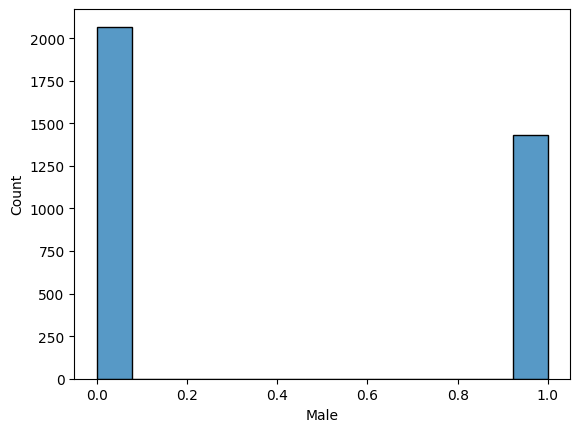

In [14]:
import seaborn as sns

sns.histplot(train_data["Male"])

In [15]:
train_data["Male"].value_counts()

Male
0    2067
1    1433
Name: count, dtype: int64

In [16]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3500 entries, 0 to 3499
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Image   3500 non-null   object
 1   Male    3500 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 54.8+ KB


/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Axes: xlabel='Male', ylabel='Count'>

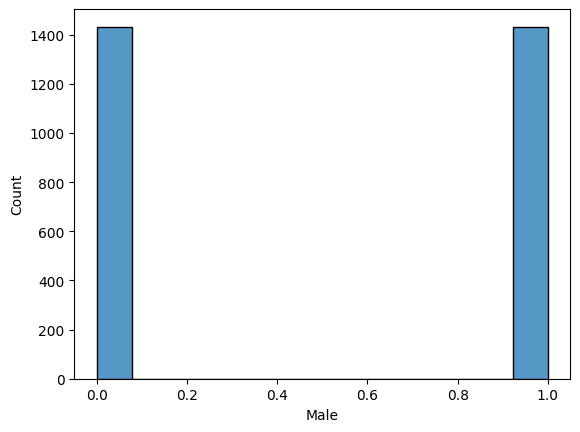

In [17]:
sample = train_data[train_data["Male"]==0].sample(n=len(train_data[train_data["Male"]==0])-len(train_data[train_data["Male"]==1]), random_state=2)
train_data = train_data[train_data["Image"].isin(sample["Image"]) == False]
train_data.reset_index(inplace=True,drop=True)
sns.histplot(train_data["Male"])

In [18]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2866 entries, 0 to 2865
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Image   2866 non-null   object
 1   Male    2866 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 44.9+ KB


In [19]:
val_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 750 entries, 0 to 749
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Image   750 non-null    object
 1   Male    750 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 11.8+ KB


In [21]:
plt.rcParams["savefig.bbox"] = 'tight'
orig_img = Image.open('/kaggle/input/genderclassificationdataset/Images/001782.jpg')

def plot(imgs, with_orig=True, row_title=None, **imshow_kwargs):
    if not isinstance(imgs[0], list):
        imgs = [imgs]

    num_rows = len(imgs)
    num_cols = len(imgs[0]) + with_orig
    fig, axs = plt.subplots(figsize=(10,50), nrows=num_rows, ncols=num_cols, squeeze=False)
    for row_idx, row in enumerate(imgs):
        row = [orig_img] + row if with_orig else row
        for col_idx, img in enumerate(row):
            ax = axs[row_idx, col_idx]
            ax.imshow(np.asarray(img), **imshow_kwargs)
            ax.set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

    if with_orig:
        axs[0, 0].set(title='Original image')
        axs[0, 0].title.set_size(8)
    if row_title is not None:
        for row_idx in range(num_rows):
            axs[row_idx, 0].set(ylabel=row_title[row_idx])

    plt.tight_layout()

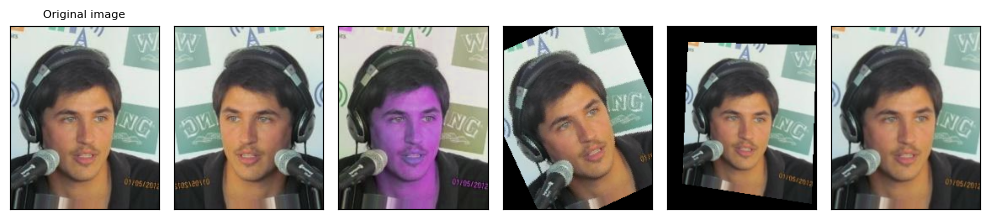

In [22]:
jitter = transforms.ColorJitter(brightness=.5, hue=.3)
hflip = transforms.RandomHorizontalFlip(p=1)
randrot = transforms.RandomRotation(degrees=(-45, 45))
randprpv = transforms.RandomPerspective(distortion_scale=0.4, p=1.0)
resize = transforms.Resize(224)
norm = transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))

jitted_imgs = [hflip(orig_img), jitter(orig_img), randrot(orig_img), randprpv(orig_img), resize(orig_img)]
plot(jitted_imgs)

In [23]:
class GenderDataset(Dataset):
    def __init__(self, data, image_folder_path, transform=None):
        self.data = data
        self.image_folder_path = image_folder_path
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        image_path = os.path.join(self.image_folder_path, self.data.iloc[idx, 0])
        # please define image convertion technique to RGB here
        image = Image.open(image_path).convert('RGB')
        gender = self.data.iloc[idx, 1]
        if self.transform:
            image = self.transform(image)
        return image, torch.tensor(gender, dtype=torch.long)

In [24]:
transform = {
    'train': transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.2),
    transforms.RandomRotation(degrees=(-45, 45)),
    transforms.RandomPerspective(distortion_scale=0.4, p=0.2),
    transforms.ColorJitter(),
    transforms.Resize(224),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    ]),
    'val': transforms.Compose([
    transforms.Resize(224),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    ]),
    'test': transforms.Compose([
    transforms.Resize(224),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    ])}

In [25]:
train_set = GenderDataset(train_data, image_folder_path=data_path+"/Images", transform=transform['train'])
train_loader = DataLoader(train_set, batch_size=32, shuffle=True)

val_set = GenderDataset(val_data, image_folder_path=data_path+"/Images", transform=transform['val'])
val_loader = DataLoader(val_set, batch_size=32, shuffle=True)

test_set = GenderDataset(test_data, image_folder_path=data_path+"/Images", transform=transform['test'])
test_loader = DataLoader(test_set, batch_size=32, shuffle=True)

In [26]:
criterion = nn.BCEWithLogitsLoss()

In [27]:
import time
from torch.autograd import Variable

def train_model(model, dataloaders, dataset_sizes, criterion, optimizer, use_gpu=torch.cuda.is_available(), epochs=10):
  # please define the training model (VGG/GoogleNet/ResNet) here
  # Train the model
    losses = []
    train_acc = []
    val_acc = []
    
    loss_freq = 20
    start_time = time.time()
    best_acc = 0
    for epoch in range(epochs):
        running_loss = 0.0
        for i, data in enumerate(dataloaders["train"], 0):
            # Get the inputs
            inputs, labels = data
            
            inputs, labels = inputs.to('cuda'), labels.to('cuda')
            
            # Zero the parameter gradients
            optimizer.zero_grad()
            
            # Forward + backward + optimize
            outputs = model(inputs)
            outputs = outputs.squeeze(1)
            loss = criterion(outputs, labels.float())
            loss.backward()
            optimizer.step()
            
            # Print statistics
            running_loss += loss.item()
            if i % loss_freq == loss_freq-1:
                print('[%d, %5d] loss: %.3f' %(epoch + 1, i + 1, running_loss / loss_freq))
                running_loss = 0.0

        losses.append(running_loss / np.mod(len(dataloaders["train"]), loss_freq))
        print(f'Epoch-{epoch+1} loss: {running_loss / np.mod(len(dataloaders["train"]), loss_freq)}')

        acc = calc_acc(model, dataloaders, epoch, "train")
        train_acc.append(acc)
        acc = calc_acc(model, dataloaders, epoch, "validation")
        val_acc.append(acc)

        training_time = time.time()-start_time
        print(f'Training time elapsed: {training_time}')
        print("=====================================================================================\n")
        torch.cuda.empty_cache()
    print(f'Total training time: {training_time}')
    print(f'Training time per epoch: {training_time/epoch+1}')
    torch.cuda.empty_cache()
    
    return losses, train_acc, val_acc

In [28]:
def calc_acc(model, dataloaders, epoch, mode):
    correct = 0
    total = 0
    with torch.no_grad():
        for data in dataloaders[mode]:
            images, labels = data
            images, labels = images.to('cuda'), labels.to('cuda')
            outputs = model(images)
            outputs = outputs.squeeze(1)
            predicted = (torch.sigmoid(outputs) > 0.5).float()
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            epoch_acc = 100 * correct / total

    print(f'{mode} accuracy: {epoch_acc}%')
    return epoch_acc

In [29]:
dataloaders = {
    "train":train_loader, "validation":val_loader, "test":test_loader
}
dataset_sizes= {
    "train":len(train_set), "validation":len(val_set), "test":len(test_set)
}

In [ ]:
train_data.to_csv('/kaggle/working/train_data.csv', index = False)
test_data.to_csv('/kaggle/working/test_data.csv', index = False) 
val_data.to_csv('/kaggle/working/val_data.csv', index = False)
torch.save(dataloaders, f"/kaggle/working/dataloaders.pth")
torch.save(dataset_sizes, f"/kaggle/working/dataset_sizes.pth")

In [30]:
def make_model(model, lr, alpha, optimizer):
    if model == "VGG16":
        model = models.vgg16()
    elif opitmizer == "VGG19":
        model = models.vgg19()
    model.classifier[6] = nn.Linear(4096, 1)
    model_vgg16.to('cuda')
    if optimizer == "Adam":
        optimizer = optim.Adam(model.parameters(), lr=lr)
    elif optimizer == "RMSProp":
        optimizer = optim.RMSprop(model.parameters(), lr=lr, alpha=alpha)
    model
    return model, optimizer

In [31]:
criterion = nn.BCEWithLogitsLoss()

In [32]:
def make_predict(model, dataloaders):
    start_time = time.time()
    y_true = torch.empty((0)).to('cuda')
    y_pred = torch.empty((0)).to('cuda')
    for data in dataloaders:
        images, labels = data
        images, labels = images.to('cuda'), labels.to('cuda')
        outputs = model(images)
        outputs = outputs.squeeze(1)
        predicted = (torch.sigmoid(outputs) > 0.5).float()
        y_true = torch.cat((y_true, labels),-1)
        y_pred = torch.cat((y_pred, predicted),-1)
    inf_time = (time.time() - start_time)/len(dataloaders)
    return inf_time, y_true, y_pred

In [33]:
def plot_train(loss, train_acc, val_acc):
    x = np.arange(0,10,1)
    fig, ax = plt.subplots(1, 2, figsize=(12, 5))

    ax[0].plot(x, train_acc, color='r', label='train acc')
    ax[0].plot(x, val_acc, color='b', label='val acc')
    ax[0].set_xlabel("Epoch(s)") 
    ax[0].set_ylabel("Accuracy") 
    ax[0].set_title("Accuracy per epoch")
    ax[0].legend()

    ax[1].plot(x, loss, color='r', label='loss')
    ax[1].set_xlabel("Epoch(s)") 
    ax[1].set_ylabel("Loss") 
    ax[1].set_title("Loss per epoch")
    ax[1].legend()

    plt.show()

In [34]:
def train_eval(model_type, lr, alpha, optimizer_type, init_state):
    if model_type == "VGG16":
        model = models.vgg16()
    elif model_type == "VGG19":
        model = models.vgg19()
    model.classifier[6] = nn.Linear(4096, 1)
    if init_state:
        model.load_state_dict(init_state)
    init_state = model.state_dict()
    model.to('cuda')
    if optimizer_type == "Adam":
        optimizer = optim.Adam(model.parameters(), lr=lr)
    elif optimizer_type == "RMSProp":
        optimizer = optim.RMSprop(model.parameters(), lr=lr, alpha=alpha)
    model
    
    use_gpu = torch.cuda.is_available()

    if use_gpu:
       model = model.to('cuda')

    print(f"{model_type}_{optimizer_type}_{lr}_{alpha}")
    loss, train_acc, val_acc = train_model(model, dataloaders, dataset_sizes, criterion, optimizer, use_gpu, 10)
    torch.save(model.state_dict(), f"/kaggle/working/{model_type}_{optimizer_type}_{lr}_{alpha}.pth")
    plot_train(loss, train_acc, val_acc)
    inf_time, ytrue, ypred = make_predict(model, dataloaders["test"])
    
    ytrue = ytrue.cpu().numpy()
    ypred = ypred.cpu().numpy()
    print(classification_report(ytrue, ypred, digits = 4))
    print("Inference Time of Model: {}".format(inf_time))
    
    cm = confusion_matrix(ytrue, ypred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)

    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix')
    plt.show()
    
    torch.cuda.empty_cache()
    
    return model, init_state

VGG16_Adam_0.0001_0
[1,    20] loss: 0.696
[1,    40] loss: 0.696
[1,    60] loss: 0.694
[1,    80] loss: 0.692
Epoch-1 loss: 0.6692290663719177
train accuracy: 56.908583391486395%
validation accuracy: 55.86666666666667%
Training time elapsed: 104.79706645011902

[2,    20] loss: 0.647
[2,    40] loss: 0.653
[2,    60] loss: 0.676
[2,    80] loss: 0.676
Epoch-2 loss: 0.6330787539482117
train accuracy: 70.44661549197488%
validation accuracy: 75.46666666666667%
Training time elapsed: 200.247318983078

[3,    20] loss: 0.603
[3,    40] loss: 0.564
[3,    60] loss: 0.598
[3,    80] loss: 0.563
Epoch-3 loss: 0.5670204222202301
train accuracy: 68.28332170272157%
validation accuracy: 71.46666666666667%
Training time elapsed: 295.6089291572571

[4,    20] loss: 0.572
[4,    40] loss: 0.530
[4,    60] loss: 0.537
[4,    80] loss: 0.487
Epoch-4 loss: 0.579989418387413
train accuracy: 75.95952547103978%
validation accuracy: 80.8%
Training time elapsed: 391.573792219162

[5,    20] loss: 0.493
[5,

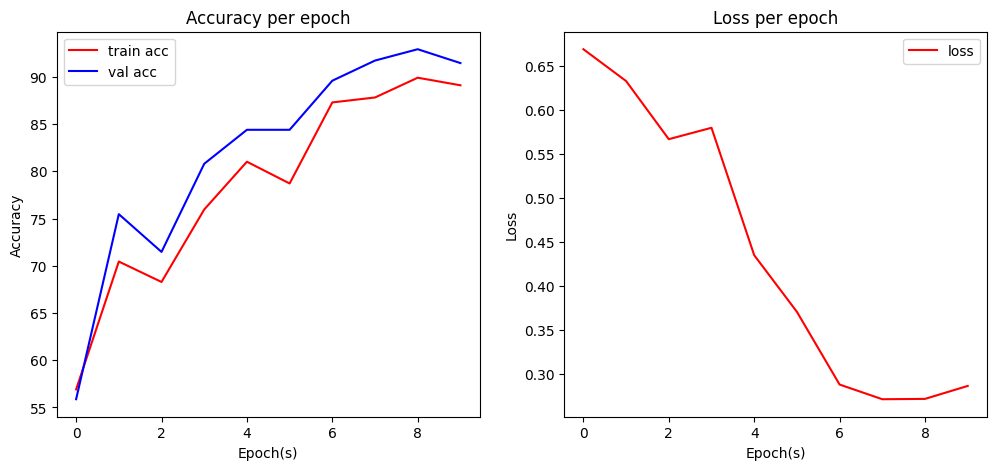

              precision    recall  f1-score   support

         0.0     0.9794    0.8739    0.9236       436
         1.0     0.8476    0.9745    0.9067       314

    accuracy                         0.9160       750
   macro avg     0.9135    0.9242    0.9152       750
weighted avg     0.9243    0.9160    0.9165       750

Inference Time of Model: 0.2934117118517558


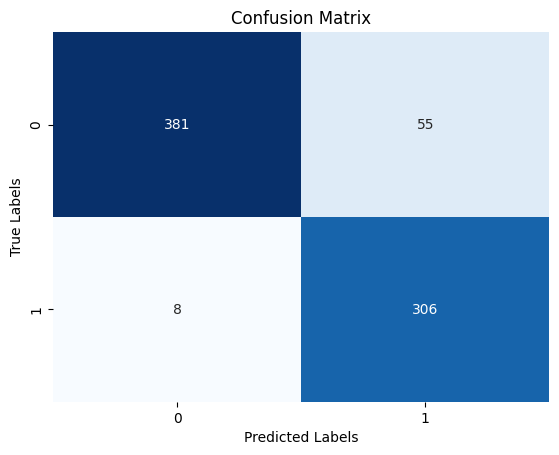

In [32]:
model1, init_state = train_eval("VGG16", 0.0001, 0, "Adam", None)
torch.save(init_state, f"/kaggle/working/vgg16_initstate.pth")

VGG16_Adam_5e-05_0
[1,    20] loss: 0.696
[1,    40] loss: 0.693
[1,    60] loss: 0.693
[1,    80] loss: 0.690
Epoch-1 loss: 0.700896394252777
train accuracy: 60.921144452198185%
validation accuracy: 60.8%
Training time elapsed: 96.5414731502533

[2,    20] loss: 0.695
[2,    40] loss: 0.693
[2,    60] loss: 0.692
[2,    80] loss: 0.673
Epoch-2 loss: 0.679112184047699
train accuracy: 63.15422191207257%
validation accuracy: 70.66666666666667%
Training time elapsed: 192.189377784729

[3,    20] loss: 0.654
[3,    40] loss: 0.656
[3,    60] loss: 0.586
[3,    80] loss: 0.615
Epoch-3 loss: 0.5698499381542206
train accuracy: 67.79483600837403%
validation accuracy: 75.33333333333333%
Training time elapsed: 287.97274017333984

[4,    20] loss: 0.574
[4,    40] loss: 0.595
[4,    60] loss: 0.548
[4,    80] loss: 0.537
Epoch-4 loss: 0.5650873601436615
train accuracy: 70.20237264480112%
validation accuracy: 74.0%
Training time elapsed: 383.65714955329895

[5,    20] loss: 0.551
[5,    40] loss: 

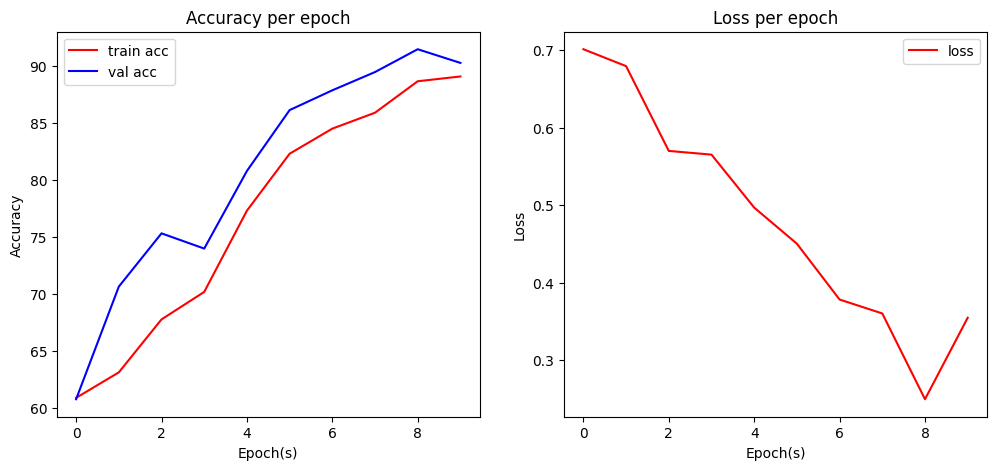

              precision    recall  f1-score   support

         0.0     0.9134    0.9197    0.9166       436
         1.0     0.8875    0.8790    0.8832       314

    accuracy                         0.9027       750
   macro avg     0.9004    0.8994    0.8999       750
weighted avg     0.9026    0.9027    0.9026       750

Inference Time of Model: 0.18162755171457926


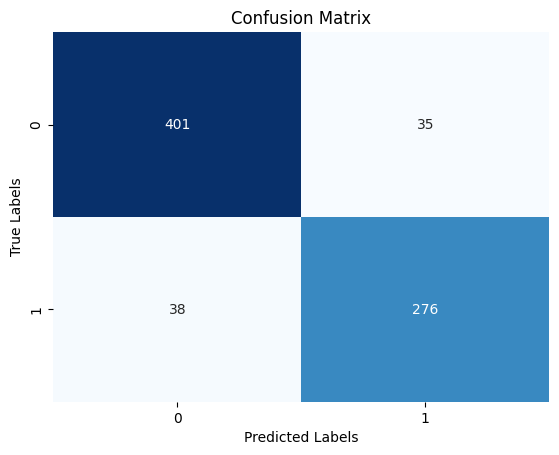

In [33]:
model2, _ = train_eval("VGG16", 0.00005, 0, "Adam", init_state)

VGG16_RMSProp_0.0001_0.9
[1,    20] loss: 0.818
[1,    40] loss: 0.694
[1,    60] loss: 0.723
[1,    80] loss: 0.696
Epoch-1 loss: 0.6819830358028411
train accuracy: 63.22400558269365%
validation accuracy: 65.06666666666666%
Training time elapsed: 95.34644532203674

[2,    20] loss: 0.699
[2,    40] loss: 0.672
[2,    60] loss: 0.642
[2,    80] loss: 0.614
Epoch-2 loss: 0.6209765613079071
train accuracy: 70.2721563154222%
validation accuracy: 74.53333333333333%
Training time elapsed: 189.86836695671082

[3,    20] loss: 0.591
[3,    40] loss: 0.627
[3,    60] loss: 0.595
[3,    80] loss: 0.577
Epoch-3 loss: 0.5514290779829025
train accuracy: 76.55268667131891%
validation accuracy: 79.33333333333333%
Training time elapsed: 285.04464888572693

[4,    20] loss: 0.557
[4,    40] loss: 0.542
[4,    60] loss: 0.539
[4,    80] loss: 0.494
Epoch-4 loss: 0.44230665266513824
train accuracy: 80.18143754361479%
validation accuracy: 86.8%
Training time elapsed: 379.20958518981934

[5,    20] loss: 

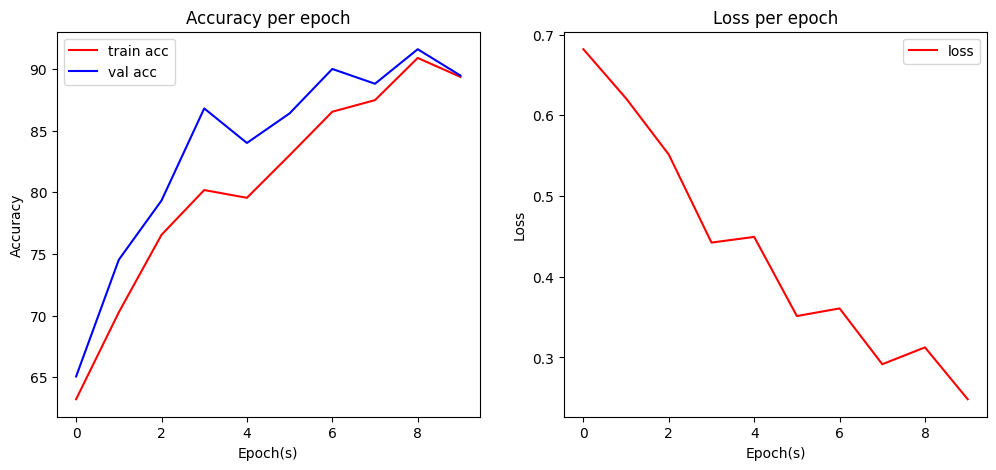

              precision    recall  f1-score   support

         0.0     0.9804    0.8050    0.8841       436
         1.0     0.7832    0.9777    0.8697       314

    accuracy                         0.8773       750
   macro avg     0.8818    0.8914    0.8769       750
weighted avg     0.8979    0.8773    0.8781       750

Inference Time of Model: 0.18155529101689658


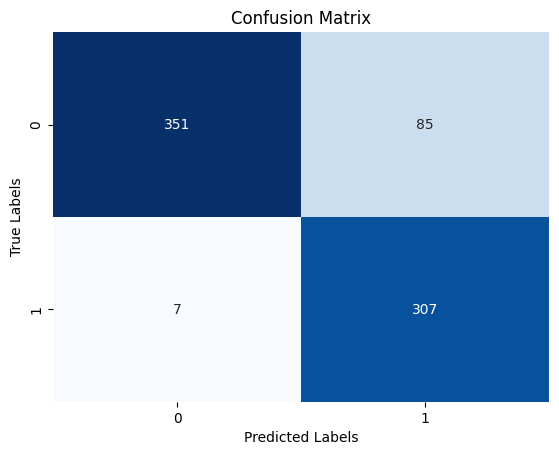

In [34]:
model3, _ = train_eval("VGG16", 0.0001, 0.9, "RMSProp", init_state)

VGG16_RMSProp_5e-05_0.5
[1,    20] loss: 0.697
[1,    40] loss: 0.694
[1,    60] loss: 0.693
[1,    80] loss: 0.675
Epoch-1 loss: 0.6415190398693085
train accuracy: 65.07327285415212%
validation accuracy: 71.2%
Training time elapsed: 94.73305821418762

[2,    20] loss: 0.638
[2,    40] loss: 0.618
[2,    60] loss: 0.622
[2,    80] loss: 0.596
Epoch-2 loss: 0.6191851079463959
train accuracy: 71.5980460572226%
validation accuracy: 77.2%
Training time elapsed: 189.34192967414856

[3,    20] loss: 0.581
[3,    40] loss: 0.589
[3,    60] loss: 0.578
[3,    80] loss: 0.552
Epoch-3 loss: 0.5685470551252365
train accuracy: 73.831123517097%
validation accuracy: 76.13333333333334%
Training time elapsed: 285.70587134361267

[4,    20] loss: 0.531
[4,    40] loss: 0.569
[4,    60] loss: 0.530
[4,    80] loss: 0.507
Epoch-4 loss: 0.5131137281656265
train accuracy: 72.08653175157013%
validation accuracy: 76.0%
Training time elapsed: 380.52387404441833

[5,    20] loss: 0.470
[5,    40] loss: 0.515
[

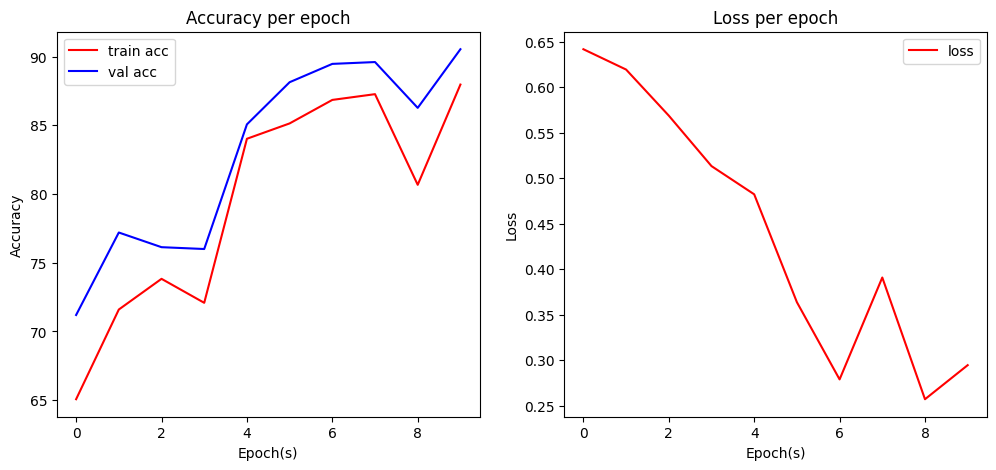

              precision    recall  f1-score   support

         0.0     0.9712    0.8509    0.9071       436
         1.0     0.8234    0.9650    0.8886       314

    accuracy                         0.8987       750
   macro avg     0.8973    0.9079    0.8978       750
weighted avg     0.9093    0.8987    0.8993       750

Inference Time of Model: 0.18259823322296143


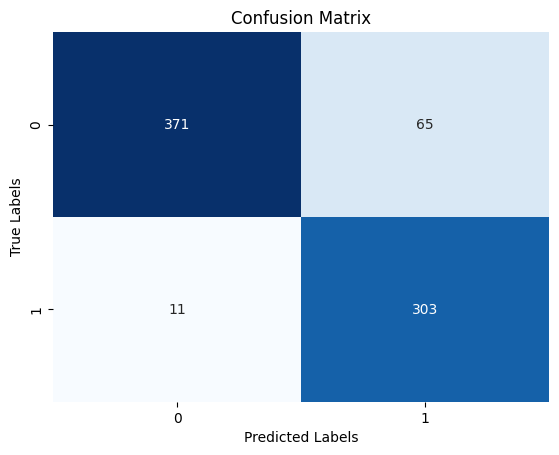

In [35]:
model4, _ = train_eval("VGG16", 0.00005, 0.5, "RMSProp", init_state)

VGG16_RMSProp_0.0001_0.5
[1,    20] loss: 0.696
[1,    40] loss: 0.702
[1,    60] loss: 0.696
[1,    80] loss: 0.718
Epoch-1 loss: 0.6711605370044709
train accuracy: 64.5847871598046%
validation accuracy: 63.2%
Training time elapsed: 102.24845838546753

[2,    20] loss: 0.709
[2,    40] loss: 0.617
[2,    60] loss: 0.636
[2,    80] loss: 0.608
Epoch-2 loss: 0.6403613328933716
train accuracy: 71.2142358688067%
validation accuracy: 74.4%
Training time elapsed: 198.08759999275208

[3,    20] loss: 0.598
[3,    40] loss: 0.565
[3,    60] loss: 0.594
[3,    80] loss: 0.582
Epoch-3 loss: 0.5978010892868042
train accuracy: 70.62107466852757%
validation accuracy: 63.06666666666667%
Training time elapsed: 294.7420048713684

[4,    20] loss: 0.550
[4,    40] loss: 0.501
[4,    60] loss: 0.582
[4,    80] loss: 0.501
Epoch-4 loss: 0.49814162254333494
train accuracy: 79.6231681786462%
validation accuracy: 84.66666666666667%
Training time elapsed: 390.09733986854553

[5,    20] loss: 0.457
[5,    40

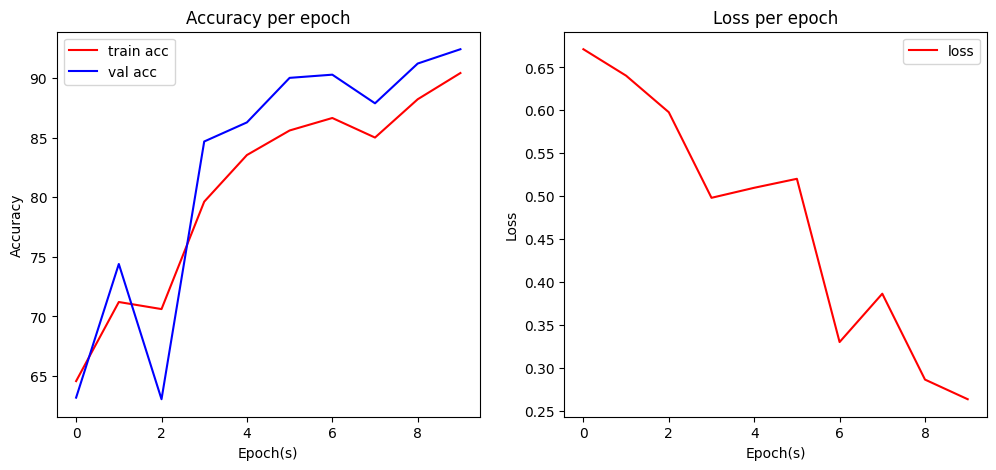

              precision    recall  f1-score   support

         0.0     0.9594    0.9220    0.9404       436
         1.0     0.8973    0.9459    0.9209       314

    accuracy                         0.9320       750
   macro avg     0.9284    0.9339    0.9306       750
weighted avg     0.9334    0.9320    0.9322       750

Inference Time of Model: 0.22991758584976196


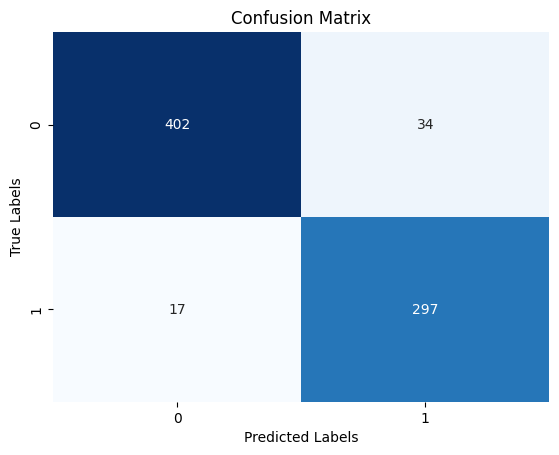

In [36]:
model5, _ = train_eval("VGG16", 0.0001, 0.5, "RMSProp", init_state)

VGG16_RMSProp_5e-05_0.9
[1,    20] loss: 0.698
[1,    40] loss: 0.694
[1,    60] loss: 0.694
[1,    80] loss: 0.698
Epoch-1 loss: 0.6562081038951874
train accuracy: 60.886252616887646%
validation accuracy: 68.26666666666667%
Training time elapsed: 95.47363185882568

[2,    20] loss: 0.626
[2,    40] loss: 0.615
[2,    60] loss: 0.635
[2,    80] loss: 0.612
Epoch-2 loss: 0.5976098537445068
train accuracy: 71.84228890439637%
validation accuracy: 76.53333333333333%
Training time elapsed: 191.2861762046814

[3,    20] loss: 0.602
[3,    40] loss: 0.587
[3,    60] loss: 0.558
[3,    80] loss: 0.587
Epoch-3 loss: 0.5150759518146515
train accuracy: 67.89951151430566%
validation accuracy: 74.8%
Training time elapsed: 287.4250719547272

[4,    20] loss: 0.570
[4,    40] loss: 0.542
[4,    60] loss: 0.511
[4,    80] loss: 0.540
Epoch-4 loss: 0.5507394880056381
train accuracy: 77.18073970690858%
validation accuracy: 78.4%
Training time elapsed: 383.14212131500244

[5,    20] loss: 0.530
[5,    40

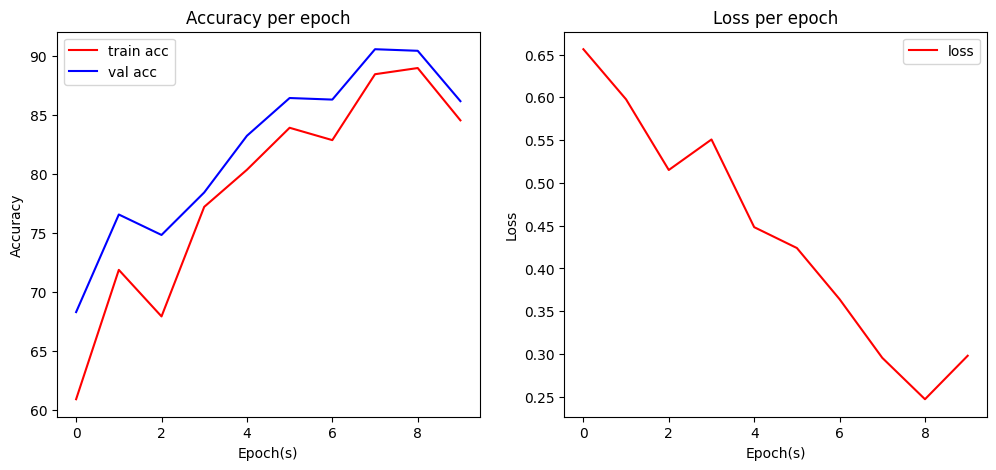

              precision    recall  f1-score   support

         0.0     0.9396    0.8211    0.8764       436
         1.0     0.7886    0.9268    0.8521       314

    accuracy                         0.8653       750
   macro avg     0.8641    0.8739    0.8642       750
weighted avg     0.8764    0.8653    0.8662       750

Inference Time of Model: 0.18734759092330933


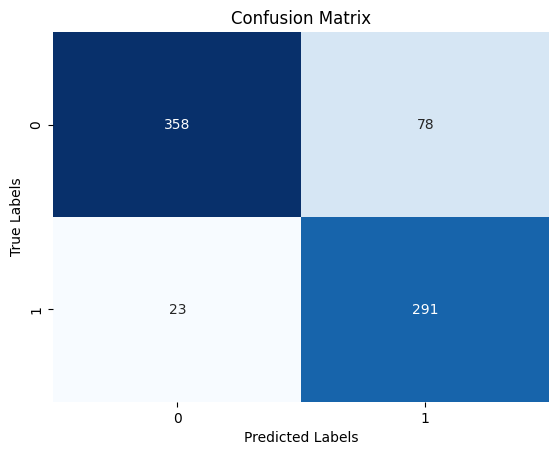

In [37]:
model6, _ = train_eval("VGG16", 0.00005, 0.9, "RMSProp", init_state)

VGG19_Adam_0.0001_0
[1,    20] loss: 0.695
[1,    40] loss: 0.694
[1,    60] loss: 0.693
[1,    80] loss: 0.693
Epoch-1 loss: 0.6932381629943848
train accuracy: 50.52337752965806%
validation accuracy: 40.53333333333333%
Training time elapsed: 128.21348690986633

[2,    20] loss: 0.687
[2,    40] loss: 0.683
[2,    60] loss: 0.656
[2,    80] loss: 0.671
Epoch-2 loss: 0.6752605736255646
train accuracy: 62.735519888346126%
validation accuracy: 69.86666666666666%
Training time elapsed: 236.83654832839966

[3,    20] loss: 0.641
[3,    40] loss: 0.641
[3,    60] loss: 0.613
[3,    80] loss: 0.641
Epoch-3 loss: 0.597474217414856
train accuracy: 67.34124214933705%
validation accuracy: 72.26666666666667%
Training time elapsed: 344.7523775100708

[4,    20] loss: 0.630
[4,    40] loss: 0.583
[4,    60] loss: 0.619
[4,    80] loss: 0.581
Epoch-4 loss: 0.5909001767635346
train accuracy: 70.90020935101187%
validation accuracy: 75.86666666666666%
Training time elapsed: 452.5285258293152

[5,    20]

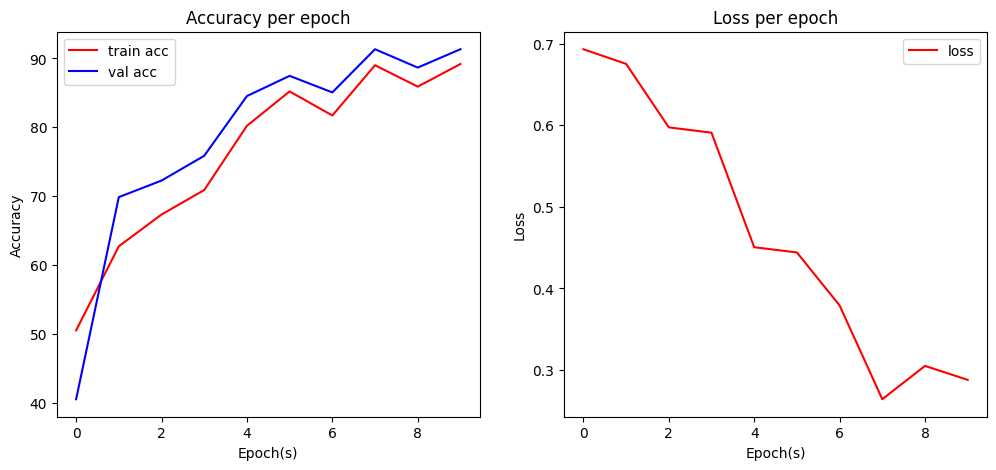

              precision    recall  f1-score   support

         0.0     0.8987    0.9358    0.9169       436
         1.0     0.9054    0.8535    0.8787       314

    accuracy                         0.9013       750
   macro avg     0.9020    0.8946    0.8978       750
weighted avg     0.9015    0.9013    0.9009       750

Inference Time of Model: 0.28048593799273175


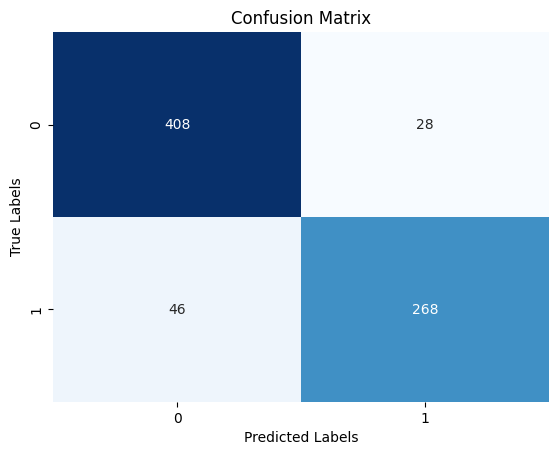

In [35]:
model7, init_state = train_eval("VGG19", 0.0001, 0, "Adam", None)
torch.save(init_state, f"/kaggle/working/vgg19_initstate.pth")

VGG19_Adam_5e-05_0
[1,    20] loss: 0.692
[1,    40] loss: 0.696
[1,    60] loss: 0.693
[1,    80] loss: 0.692
Epoch-1 loss: 0.6894282937049866
train accuracy: 50.0%
validation accuracy: 60.0%
Training time elapsed: 109.90494084358215

[2,    20] loss: 0.695
[2,    40] loss: 0.692
[2,    60] loss: 0.689
[2,    80] loss: 0.680
Epoch-2 loss: 0.6644364356994629
train accuracy: 64.34054431263084%
validation accuracy: 63.86666666666667%
Training time elapsed: 219.00840997695923

[3,    20] loss: 0.639
[3,    40] loss: 0.644
[3,    60] loss: 0.625
[3,    80] loss: 0.599
Epoch-3 loss: 0.609268718957901
train accuracy: 68.702023726448%
validation accuracy: 73.33333333333333%
Training time elapsed: 328.771443605423

[4,    20] loss: 0.600
[4,    40] loss: 0.575
[4,    60] loss: 0.568
[4,    80] loss: 0.595
Epoch-4 loss: 0.6116699695587158
train accuracy: 73.58688066992323%
validation accuracy: 74.93333333333334%
Training time elapsed: 438.57295322418213

[5,    20] loss: 0.528
[5,    40] loss: 

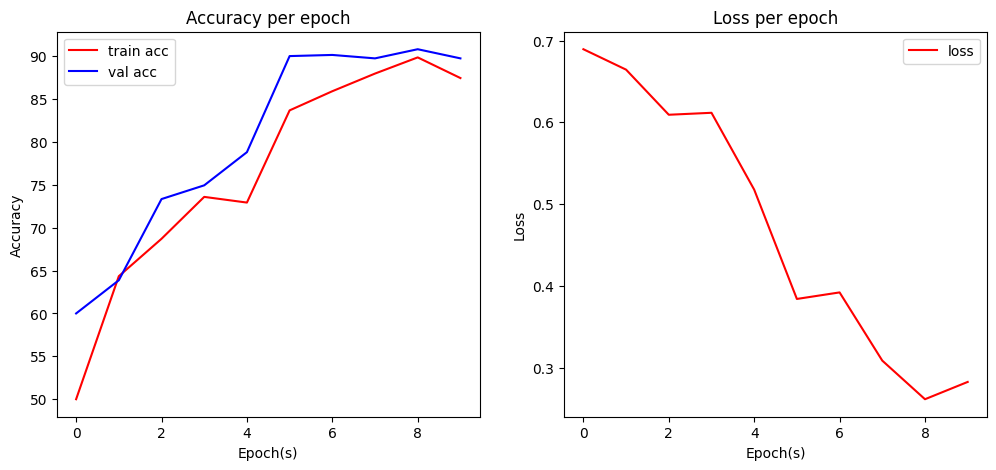

              precision    recall  f1-score   support

         0.0     0.8969    0.9174    0.9070       436
         1.0     0.8816    0.8535    0.8673       314

    accuracy                         0.8907       750
   macro avg     0.8892    0.8855    0.8872       750
weighted avg     0.8905    0.8907    0.8904       750

Inference Time of Model: 0.22619788845380148


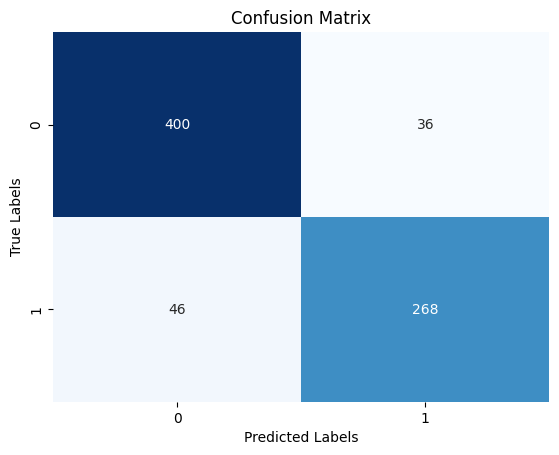

In [36]:
model8, _ = train_eval("VGG19", 0.00005, 0, "Adam", init_state)

VGG19_RMSProp_0.0001_0.9
[1,    20] loss: 0.798
[1,    40] loss: 0.694
[1,    60] loss: 0.691
[1,    80] loss: 0.699
Epoch-1 loss: 0.6931343972682953
train accuracy: 54.152128401953945%
validation accuracy: 53.2%
Training time elapsed: 108.47670769691467

[2,    20] loss: 0.933
[2,    40] loss: 0.680
[2,    60] loss: 0.682
[2,    80] loss: 0.682
Epoch-2 loss: 0.6494756281375885
train accuracy: 61.89811584089323%
validation accuracy: 64.13333333333334%
Training time elapsed: 216.57953476905823

[3,    20] loss: 0.659
[3,    40] loss: 0.654
[3,    60] loss: 0.638
[3,    80] loss: 0.643
Epoch-3 loss: 0.6220796436071396
train accuracy: 60.29309141660851%
validation accuracy: 57.733333333333334%
Training time elapsed: 324.4796710014343

[4,    20] loss: 0.636
[4,    40] loss: 0.606
[4,    60] loss: 0.617
[4,    80] loss: 0.567
Epoch-4 loss: 0.5630220711231232
train accuracy: 75.57571528262386%
validation accuracy: 78.8%
Training time elapsed: 431.9176917076111

[5,    20] loss: 0.580
[5,   

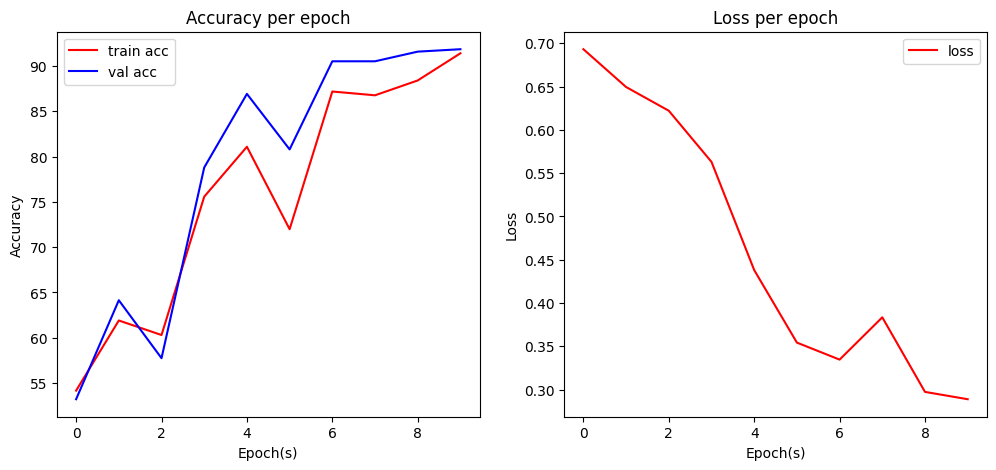

              precision    recall  f1-score   support

         0.0     0.9131    0.9404    0.9266       436
         1.0     0.9136    0.8758    0.8943       314

    accuracy                         0.9133       750
   macro avg     0.9134    0.9081    0.9104       750
weighted avg     0.9133    0.9133    0.9131       750

Inference Time of Model: 0.22644681731859842


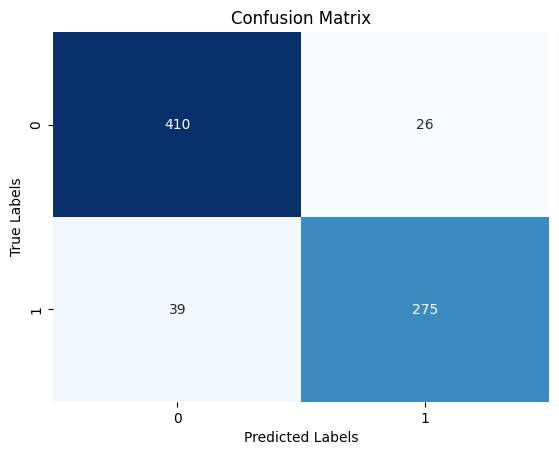

In [37]:
model9, _ = train_eval("VGG19", 0.0001, 0.9, "RMSProp", init_state)

VGG19_RMSProp_0.0001_0.5
[1,    20] loss: 0.709
[1,    40] loss: 0.697
[1,    60] loss: 0.697
[1,    80] loss: 0.700
Epoch-1 loss: 0.6952892899513244
train accuracy: 62.03768318213538%
validation accuracy: 68.0%
Training time elapsed: 108.21942329406738

[2,    20] loss: 0.701
[2,    40] loss: 0.669
[2,    60] loss: 0.659
[2,    80] loss: 0.651
Epoch-2 loss: 0.721153524518013
train accuracy: 68.35310537334264%
validation accuracy: 71.06666666666666%
Training time elapsed: 216.03948426246643

[3,    20] loss: 0.730
[3,    40] loss: 0.622
[3,    60] loss: 0.634
[3,    80] loss: 0.626
Epoch-3 loss: 0.6537705004215241
train accuracy: 70.44661549197488%
validation accuracy: 72.53333333333333%
Training time elapsed: 324.22545337677

[4,    20] loss: 0.619
[4,    40] loss: 0.578
[4,    60] loss: 0.592
[4,    80] loss: 0.585
Epoch-4 loss: 0.6444928765296936
train accuracy: 76.41311933007677%
validation accuracy: 78.13333333333334%
Training time elapsed: 432.21269607543945

[5,    20] loss: 0.5

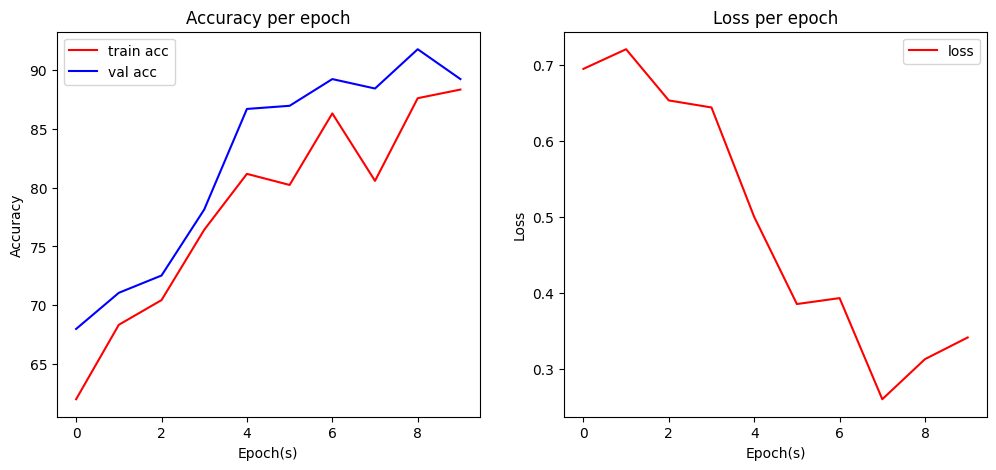

              precision    recall  f1-score   support

         0.0     0.9838    0.8349    0.9032       436
         1.0     0.8105    0.9809    0.8876       314

    accuracy                         0.8960       750
   macro avg     0.8972    0.9079    0.8954       750
weighted avg     0.9112    0.8960    0.8967       750

Inference Time of Model: 0.23513361811637878


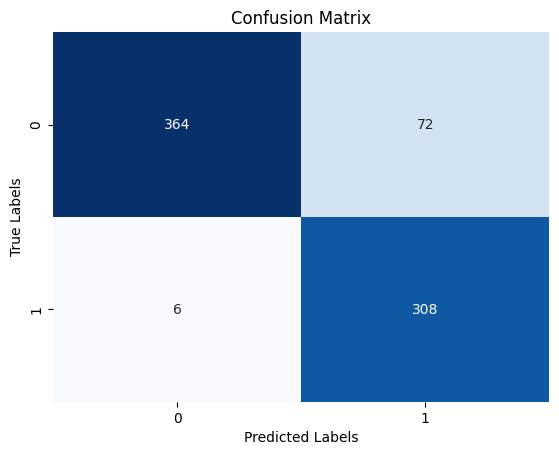

In [38]:
model10, _ = train_eval("VGG19", 0.0001, 0.5, "RMSProp", init_state)

VGG19_RMSProp_5e-05_0.9
[1,    20] loss: 0.702
[1,    40] loss: 0.694
[1,    60] loss: 0.710
[1,    80] loss: 0.686
Epoch-1 loss: 0.6553278863430023
train accuracy: 58.862526168876485%
validation accuracy: 56.666666666666664%
Training time elapsed: 110.20099258422852

[2,    20] loss: 0.662
[2,    40] loss: 0.636
[2,    60] loss: 0.627
[2,    80] loss: 0.593
Epoch-2 loss: 0.6102417171001434
train accuracy: 65.10816468946267%
validation accuracy: 67.6%
Training time elapsed: 220.94779515266418

[3,    20] loss: 0.599
[3,    40] loss: 0.574
[3,    60] loss: 0.591
[3,    80] loss: 0.587
Epoch-3 loss: 0.5916927993297577
train accuracy: 64.89881367759943%
validation accuracy: 65.46666666666667%
Training time elapsed: 331.4399194717407

[4,    20] loss: 0.589
[4,    40] loss: 0.565
[4,    60] loss: 0.520
[4,    80] loss: 0.538
Epoch-4 loss: 0.4954697400331497
train accuracy: 71.63293789253315%
validation accuracy: 74.93333333333334%
Training time elapsed: 441.883585691452

[5,    20] loss: 0

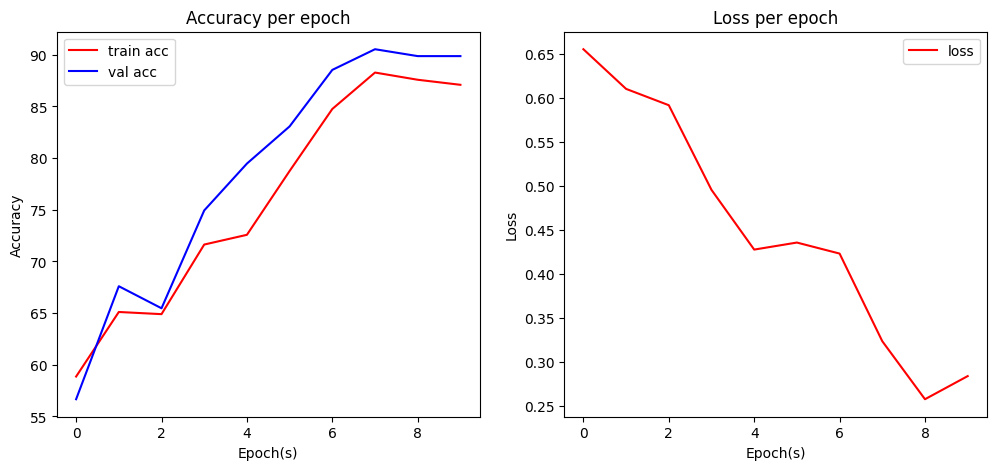

              precision    recall  f1-score   support

         0.0     0.8768    0.9633    0.9180       436
         1.0     0.9410    0.8121    0.8718       314

    accuracy                         0.9000       750
   macro avg     0.9089    0.8877    0.8949       750
weighted avg     0.9037    0.9000    0.8987       750

Inference Time of Model: 0.2331146001815796


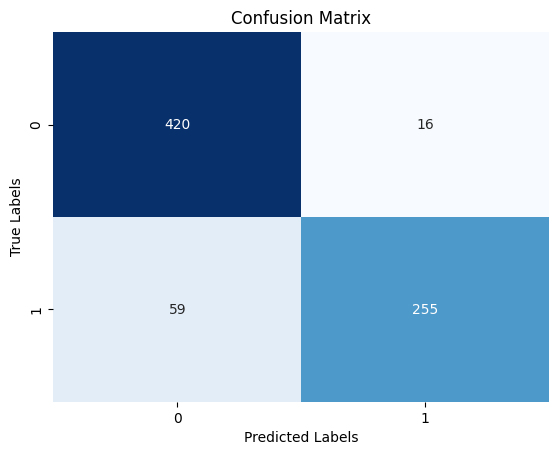

In [39]:
model11, _ = train_eval("VGG19", 0.00005, 0.9, "RMSProp", init_state)

VGG19_RMSProp_5e-05_0.5
[1,    20] loss: 0.697
[1,    40] loss: 0.687
[1,    60] loss: 0.684
[1,    80] loss: 0.663
Epoch-1 loss: 0.6146710395812989
train accuracy: 64.16608513607815%
validation accuracy: 64.66666666666667%
Training time elapsed: 109.97624492645264

[2,    20] loss: 0.639
[2,    40] loss: 0.617
[2,    60] loss: 0.643
[2,    80] loss: 0.607
Epoch-2 loss: 0.5748465925455093
train accuracy: 69.46964410327983%
validation accuracy: 74.0%
Training time elapsed: 220.81287145614624

[3,    20] loss: 0.612
[3,    40] loss: 0.605
[3,    60] loss: 0.594
[3,    80] loss: 0.607
Epoch-3 loss: 0.5631602436304093
train accuracy: 72.8890439637125%
validation accuracy: 74.93333333333334%
Training time elapsed: 330.8910503387451

[4,    20] loss: 0.535
[4,    40] loss: 0.609
[4,    60] loss: 0.539
[4,    80] loss: 0.571
Epoch-4 loss: 0.525576862692833
train accuracy: 63.538032100488486%
validation accuracy: 65.46666666666667%
Training time elapsed: 440.87613129615784

[5,    20] loss: 0.

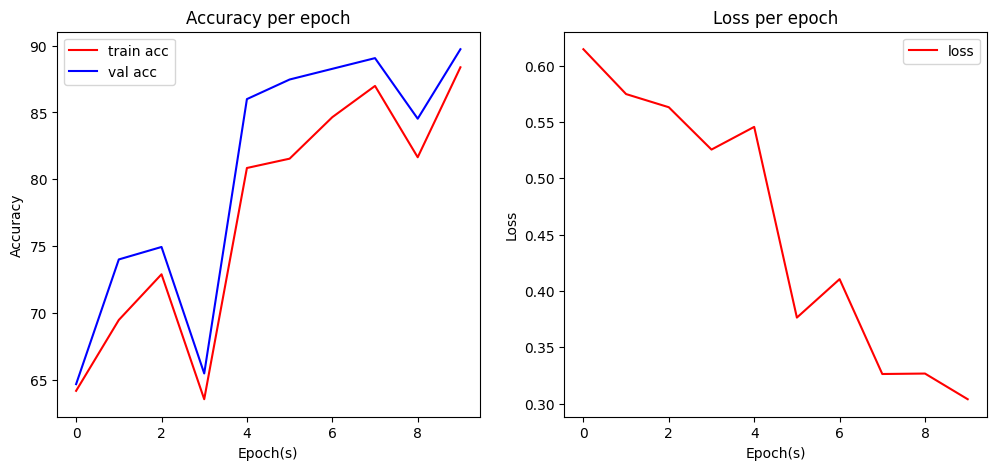

              precision    recall  f1-score   support

         0.0     0.8960    0.9289    0.9122       436
         1.0     0.8960    0.8503    0.8725       314

    accuracy                         0.8960       750
   macro avg     0.8960    0.8896    0.8924       750
weighted avg     0.8960    0.8960    0.8956       750

Inference Time of Model: 0.23690077662467957


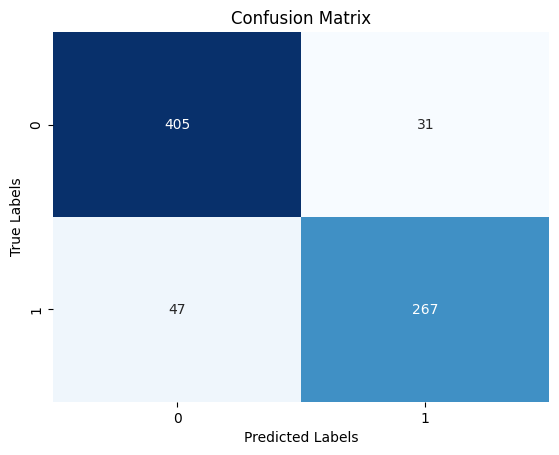

In [40]:
model12, _ = train_eval("VGG19", 0.00005, 0.5, "RMSProp", init_state)

In [41]:
torch.cuda.empty_cache()